# Demystifying Generative Adversarial Networks (GANs)

    The easiest way to understand what Generative Adversarial Networks (GANs) are is through a simple analogy.
    Suppose there is a shop which buys certain kinds of wine from a customer which they will later resell.

![GAN_Real](gan_real.jpeg)

    However, there are nefarious customers who sell fake wine in order to get money. In this case, the shop owner has to be able to distinguish between the fake and authentic wines.

![GAN_Fake](gan_fake.jpeg)

    You can imagine that initially, the forger might make a lot of mistakes when trying to sell the fake wine and it will be easy for the shop owner to identify that the wine is not authentic. Because of these failures, the forger will keep on trying different techniques to simulate authentic wines and some will eventually be successful. Now that the forger knows that certain techniques got past the shop owner's checks, he can start to further improve the fake wines based on those techniques.

    At the same time, the shop owner would probably get some feedback from other shop owners or wine experts that some of the wines that she has are not original. This means that the shop owner would have to improve how she determines whether a wine is fake or authentic. The goal of the forger is to create wines that are indistinguishable from authentic ones and the goal of the shop owner is to accurately tell if a wine is real or not. This back-and-forth competition is the main idea behind GANs.

## Components of a Generative Adversarial Network
    Using the example above, we can come up with the architecture of a GAN.

![GAN_Model](gan_model.jpeg)

    There are two major components within GANs: the generator and the discriminator. The shop owner in the example is known as a discriminator and is usually a convolutional neural network (since GANs are mainly used for image tasks) which assigns a probability that the image is real or fake.

    The forger is known as the generator and is also typically a convolutional neural network (with deconvolution layers). This network takes some noise vector and outputs an image. When training the generator, it learns which areas of the image to improve/change so that the discriminator would have a hard time differentiating its generated images from the real ones.

    The generator keeps producing images that are closer in appearance to the real images while the discriminator is trying to determine the differences between real and fake images. The ultimate goal is to have a generator that can produce images which are indistinguishable from the real ones.
    
### Lets begin with the implementation of Generative Adversial Networks (GANs)

## Check Colaboratory Jupyter Notebook Runtime Type and Load Necessary Libraries

In [0]:
# check if the Goolge Colaboratory Jupyter notebook is running on a GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
# import necessary libraries
from numpy import zeros, ones, expand_dims, vstack
from numpy.random import randn, randint, random
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.initializers import RandomNormal
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.datasets import mnist
from IPython.display import Image
import glob
import imageio
import time

Using TensorFlow backend.


## Explore MNIST Handwritten Digits Dataset

- It is a dataset of 70,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.
- Keras provides access to the MNIST dataset via the mnist.load_dataset( ) function. It returns two tuples, one with the input and output elements for the standard training dataset and another with the input and output elements for the standard test dataset.
- We can see that there are 60K examples in the training set and 10K in the test set and that each image is a square of 28 by 28 pixels.

In [0]:
# load images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# check data shape
print(f'X Train shape {X_train.shape}, Y Train shape {y_train.shape}')
print(f'X Test shape {X_test.shape}, Y Test shape {y_test.shape}')

X Train shape (60000, 28, 28), Y Train shape (60000,)
X Test shape (10000, 28, 28), Y Test shape (10000,)


> The images are grayscale with a black background (0 pixel value) and the handwritten digits in white (pixel values near 255). This means if the images were plotted, they would be mostly black with a white digit in the middle.

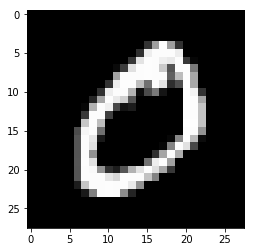

In [0]:
# checkout one of the training images
plt.imshow(X_train[1], cmap='gray')

> Alternately, the images are easier to review when we reverse the colors and plot the background as white and the handwritten digits in black.

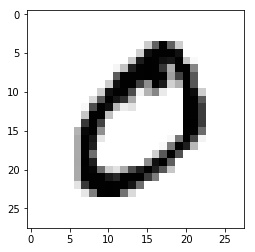

In [0]:
# reverse the color map
plt.imshow(X_train[1], cmap='gray_r')

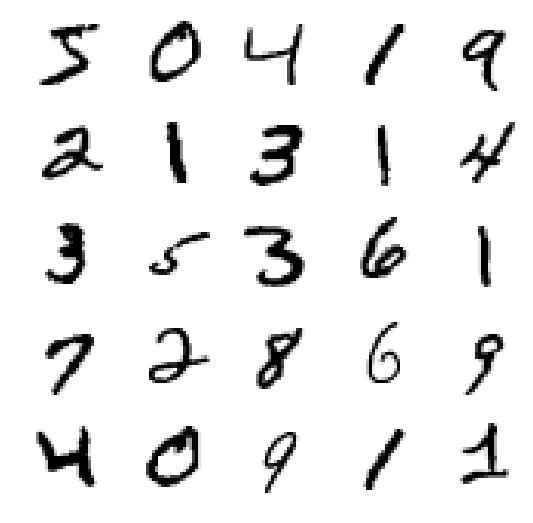

In [0]:
# checkout first 25 images from training dataset
fig = plt.figure(figsize=(9,9))
    
# plot images
for i in range(25):
    # define subplot
    plt.subplot(5, 5, 1 + i)
    # turn off axis
    plt.axis('off')
    # plot raw pixel data
    plt.imshow(X_train[i], cmap='gray_r')

## Build Generator Model

![Generator_Model](Generator-Model.png)

- The generator model is responsible for creating new, fake but plausible images of handwritten digits. It does this by taking a point from the latent space as input and outputting a square grayscale image.

> Inputs: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.

> Outputs: Two-dimensional square grayscale image of 28×28 pixels with pixel values in [-1,1].

- Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 28×28 or 784 values.

- ### Dense Layer
    - The Dense layer is the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 14×14 or 196 nodes, and an image one quarter the size (one eighth the area) would be 7×7 or 49 nodes.

    - We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks where we have many parallel filters resulting in multiple parallel activation maps called feature maps with different interpretations of the input. We want the same thing in reverse; many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create or generate.

    - Therefore, the first hidden layer, the Dense, needs enough nodes for multiple low-resolution versions of our output image, such as 128. The activations from these nodes can then be reshaped into something image-like to pass into a convolutional layer, such as 128 different 7×7 feature maps.
    
- ### Deconvolution
    - The next major architectural innovation involves upsampling the low-resolution image to a higher resolution version of the image. There are two common ways to do this upsampling process, sometimes called deconvolution.

    - One way is to use an UpSampling2D layer (like a reverse pooling layer) followed by a normal Conv2D layer. The other and perhaps more modern way is to combine these two operations into a single layer, called a Conv2DTranspose. We will use this latter approach for our generator.

    - The Conv2DTranspose layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (double their width and height dimensions). It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to avoid a checkerboard pattern that can be observed when upsampling. This can be repeated to arrive at our 28×28 output image.
    
- We will use Batch Normalization with momentum of 0.8, LeakyReLU with a default slope of 0.2 and Dropout Layer to avoid overfitting.

- ### Output Layer
    - The output layer of the model is a Conv2D with one filter and a kernel size of 4×4 and ‘same’ padding, designed to create a single feature map and preserve its dimensions at 28×28 pixels. A sigmoid activation is used to ensure output values are in the desired range of [-1,1].


### Best Practices for Generator Model

#### 1. Use Gaussian Weight Initialization

* Before a neural network can be trained, the model weights (parameters) must be initialized to small random variables.

* The best practice for DCGAN models is to initialize all weights using a zero-centered Gaussian distribution (the normal or bell-shaped distribution) with a standard deviation of 0.02.

* The same weight initializer instance could be used for each layer in a given model.

#### 2. Upsample Using Strided Convolutions

* The generator model must generate an output image given as input at a random point from the latent space.

* The recommended approach for achieving this is to use a transpose convolutional layer with a strided convolution. This is a special type of layer that performs the convolution operation in reverse. Intuitively, this means that setting a stride of 2×2 will have the opposite effect, upsampling the input instead of downsampling it in the case of a normal convolutional layer.

* By stacking a transpose convolutional layer with strided convolutions, the generator model is able to scale a given input to the desired output dimensions. The effect is the model will upsample the input for example  from 64×64 to 128×128.

#### 3. Use Batch Normalization

* Batch normalization standardizes the activations from a prior layer to have a zero mean and unit variance. This has the effect of stabilizing the training process.

* Batch normalization is used after the activation of convolution in the discriminator model and transpose convolutional layers in the generator model.

* It is added to the model after the hidden layer, but before the activation, such as LeakyReLU.

#### 4. Use LeakyReLU

* The Rectified Linear Activation Unit or ReLU, is a simple calculation that returns the value provided as input directly or the value 0.0 if the input is 0.0 or less. It has become a best practice when developing deep convolutional neural networks.

* The best practice for GANs is to use a variation of the ReLU that allows some values less than zero and learns where the cut-off should be in each node. This is called the Leaky Rectified Linear Activation Unit or LeakyReLU.

* A negative slope can be specified for the LeakyReLU and the default value of 0.2 is recommended.

#### 5. Use Dropout

- It is recommended to use Dropout to reduce Overfitting in the generator model.

#### 6. Use Hyperbolic Tangent Activation Function

- It is recommended to use the hyperbolic tangent activation function as the output for the generator model.

In [0]:
# define generator model
def build_generator(latent_dim=100):
    # initialize Sequential model
    model = Sequential()
    
    # initialize Gaussian Weight
    init = RandomNormal(mean=0.0, stddev=0.02)
    
    # base 7x7 image
    model.add(Dense(128 * 7 * 7, input_dim=latent_dim, kernel_initializer=init))
    #model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))
    
    # upsample from 7x7 to 14x14
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    # upsample from 14x14 to 28x28
    model.add(Conv2DTranspose(filters=128, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    
    # output 28x28x1
    model.add(Conv2D(1, kernel_size=(4,4), padding='same', activation='tanh', kernel_initializer=init))
    return model

# create the generator model
g_model = build_generator()

# generator model summary
g_model.summary()







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 128)       0         

> We can see that the first hidden layer has 6,272 parameters or 128 * 7 * 7, the activations of which are reshaped into 128 7×7 feature maps. The feature maps are then upscaled via the two Conv2DTranspose layers to the desired output shape of 28×28, until the output layer where a single activation map is output.

### Plot Generator Model

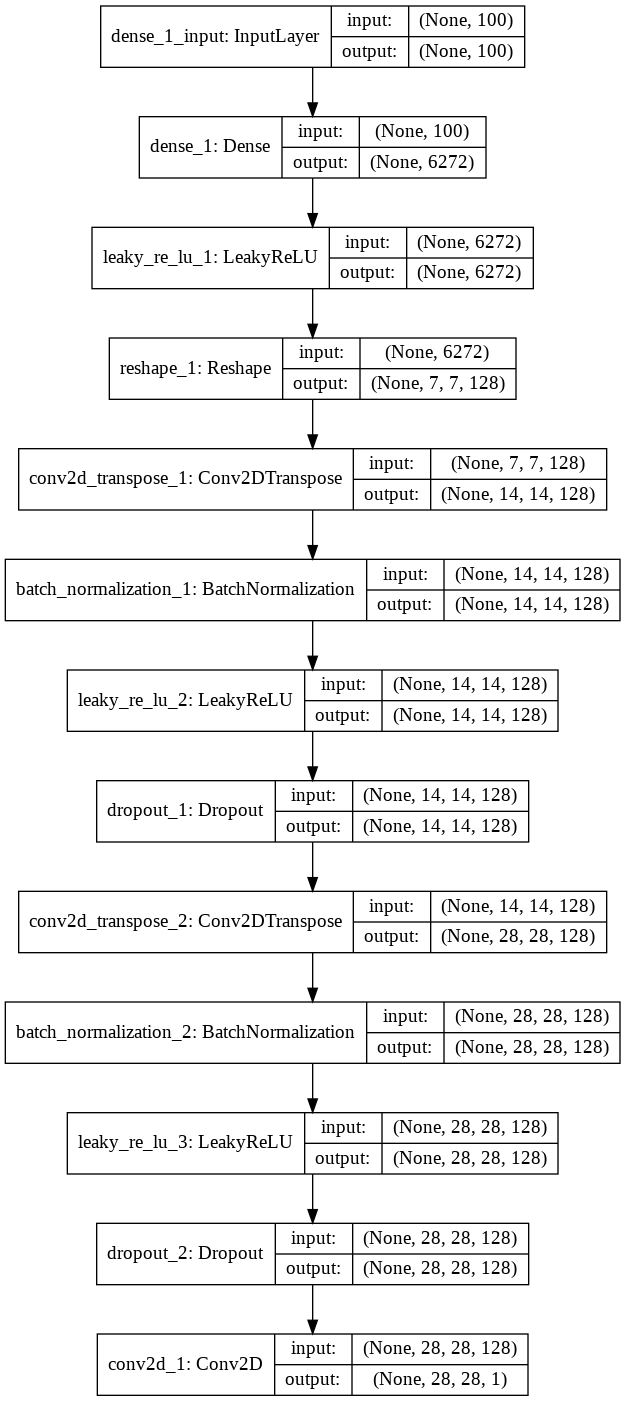

In [0]:
plot_model(g_model, to_file='dcgan_generator_model_plot.png', show_shapes=True, show_layer_names=True)
Image(filename='dcgan_generator_model_plot.png', retina=True)

## Build Discriminator Model

![Discriminator_Model](Discriminator-Model.png)

- The discriminator model must take samples of real and fake images as input and output a classification prediction as to whether the sample is real or fake.

> Inputs: Image with one channel and 28×28 pixels in size.

> Outputs: Binary classification, likelihood the sample is real or fake.

- The discriminator model has 4 convolutional layers with an increment of 2xn filters, a kernel size of 4 and larger than normal stride of 2. The model has no pooling layers and a single node in the output layer with sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the binary cross entropy loss function which is appropriate for binary classification.

- We can see that the aggressive 2×2 stride acts to down-sample the input image, first from 28×28 to 14×14, then to 7×7, before the model makes an output prediction. This pattern is by design as we do not use pooling layers and use a large stride to achieve a similar downsampling effect.

- We will use some best practices in defining the discriminator model, such as the use of LeakyReLU instead of ReLU, using Dropout and using Adam version of Stochastic Gradient Descent with a learning rate of 0.0002 and a momentum of 0.5.

### Best Practices for building Discriminator Model

#### 1. Use Gaussian Weight Initialization

* Before a neural network can be trained, the model weights (parameters) must be initialized to small random variables.

* The best practice for DCGAN models is to initialize all weights using a zero-centered Gaussian distribution (the normal or bell-shaped distribution) with a standard deviation of 0.02.

* The same weight initializer instance could be used for each layer in a given model.

#### 2. Downsample Using Strided Convolutions

* It is standard practice with deep convolutional networks to use pooling layers to downsample the input and feature maps with the depth of the network. This is not recommended for DCGAN instead they recommend downsampling using strided convolutions.

* This involves defining a convolutional layer as per normal, but instead of using the default two-dimensional stride of (1,1), change it to (2,2). This has the effect of downsampling the input, specifically halving the width and height of the input, resulting in output feature maps with one quarter the area.

#### 3. Use LeakyReLU

* The Rectified Linear Activation Unit or ReLU, is a simple calculation that returns the value provided as input directly, or the value 0.0 if the input is 0.0 or less. It has become a best practice when developing deep convolutional neural networks.

* The best practice for GANs is to use a variation of the ReLU that allows some values less than zero and learns where the cut-off should be in each node. This is called the Leaky Rectified Linear Activation Unit or LeakyReLU.

* A negative slope can be specified for the LeakyReLU and the default value of 0.2 is recommended.

#### 4. Use Dropout

- It is recommended to use Dropout to reduce Overfitting in the discriminator model.

#### 5. Use Batch Normalization

* Batch normalization standardizes the activations from a prior layer to have a zero mean and unit variance. This has the effect of stabilizing the training process.

* Batch normalization is used after the activation of convolution in the discriminator model and transpose convolutional layers in the generator model.

* It is added to the model after the hidden layer, but before the activation, such as LeakyReLU.

#### 6. Use Adam Stochastic Gradient Descent

* Stochastic Gradient Descent or SGD, is the standard algorithm used to optimize the weights of convolutional neural network models.

* The best practice for training DCGAN models is to use the Adam version of Stochastic Gradient Descent with a learning rate of 0.0002 and beta1 momentum value of 0.5 instead of the default of 0.9.

* The Adam optimization algorithm with this configuration is recommended when both optimizing the discriminator and generator models.

In [0]:
# define discriminator model
def build_discriminator():
    # initialize Sequential model
    model = Sequential()
    
    # initialize Gaussian Weight
    init = RandomNormal(mean=0.0, stddev=0.02)
    
    # input 28x28 real and fake images and downsample to 14x14
    model.add(Conv2D(filters=64, kernel_size=(4,4), strides=(2,2), padding='same', input_shape=[28, 28, 1], kernel_initializer=init))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    
    # 2D Convolution Layer
    model.add(Conv2D(filters=128, kernel_size=(4,4), padding='same', kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    
    # downsample from 14x14 to 7x7
    model.add(Conv2D(filters=256, kernel_size=(4,4), strides=(2,2), padding='same', kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    
    # 2D Convolution Layer
    model.add(Conv2D(filters=512, kernel_size=(4,4), padding='same', kernel_initializer=init))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.5))
    
    # flatten feature maps
    model.add(Flatten())
    
    # real/fake output
    model.add(Dense(1, activation='sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5), metrics=['accuracy'])
    return model

# create the discriminator model
d_model = build_discriminator()

# discriminator model summary
d_model.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1088      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       131200    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________

### Plot Discriminator Model

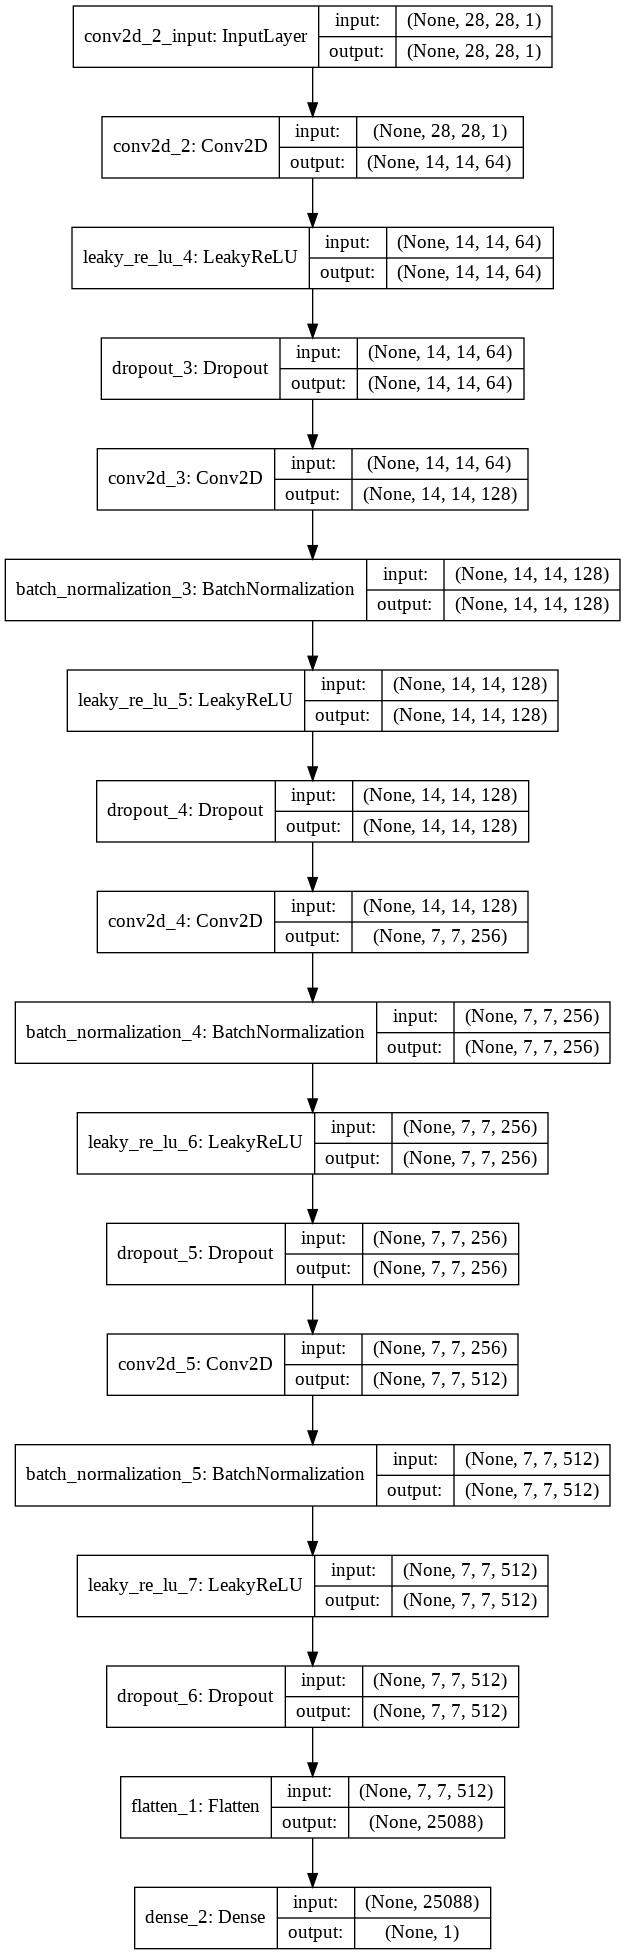

In [0]:
plot_model(d_model, to_file='dcgan_discriminator_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='dcgan_discriminator_model_plot.png')

## Build GAN Model

![Generative_Adversarial_Network_Model](Generative-Adversarial-Network-Model.png)

- The weights in the generator model are updated based on the performance of the discriminator model. When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less. This defines the zero-sum or adversarial relationship between these two models.

- There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that combines the generator and discriminator models. Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified and the output of this larger model can be used to update the model weights of the generator. To be clear, we are not talking about a new third model, just a new logical model that uses the already defined layers and weights from the standalone generator and discriminator models.

- Only the discriminator is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner on examples of each real and fake images.

- The generator model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they cannot be updated and overtrained on fake examples.

> Inputs: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.

> Outputs: Binary classification, likelihood the sample is real or fake.

- The build_gan( ) function below takes as arguments the already defined generator and discriminator models and creates the new logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

- The GAN model then uses the same binary cross entropy loss function as the discriminator and the efficient Adam version of Stochastic Gradient Descent with the learning rate of 0.0002 and momentum 0.5 recommended when training deep convolutional GANs.

In [0]:
# combine the generator and discriminator model
def build_gan(g_model, d_model):
    # Do not train weights in the discriminator
    d_model.trainable = False   
    # connect generator and discriminator model
    model = Sequential()
    # add generator
    model.add(g_model)
    # add discriminator
    model.add(d_model)
    # compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return model

# create logical GAN model
gan_model = build_gan(g_model, d_model)

# GAN model summary
gan_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 28, 28, 1)         1161089   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 2783169   
Total params: 3,944,258
Trainable params: 1,160,577
Non-trainable params: 2,783,681
_________________________________________________________________


### Plot GAN Model

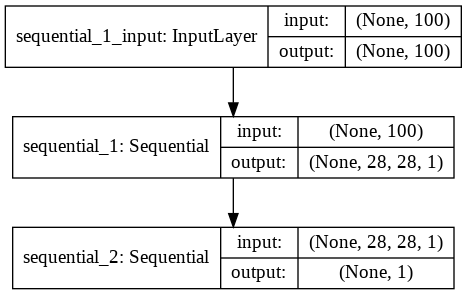

In [0]:
plot_model(gan_model, to_file='dcgan_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='dcgan_plot.png')

## Load Real Images Dataset

### Best Practice for Deep Convolutional GANs

#### Scale Images to the Range [-1,1]
- It is recommended that real images used to train the discriminator are scaled so that their pixel values are in the range [-1,1]. This is so that the discriminator will always receive real and fake images as input that have pixel values in the same range.

- The images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of images as input, where each image has one or more channels. We must update the images to have an additional dimension for the grayscale channel. We can do this using the expand_dims( ) NumPy function and specify the final dimension for the channels-last image format.

- Finally, we must scale the pixel values from the range of unsigned integers in [0,255] to the normalized range of [-1,1].

In [0]:
# load and prepare MNIST training images
def load_real_samples():
    # load MNIST dataset
    (train_images, _), (_, _) = mnist.load_data()
    # expand to 3D i.e add channel dimension
    train_images = expand_dims(train_images, axis=-1)
    # convert from unsigned ints to floats
    train_images = train_images.astype('float32')
    # scale from [0,255] to [0,1]
    #dataset = train_images / 255.0
    # scale from [0,255] to [-1,1]
    dataset = (train_images - 127.5) / 127.5
    return dataset

## Implement Positve or Negative Label Smoothing

### Best Practices for Deep Convolutional GANs

#### Use Label Smoothing

- It is common to use the class label 1 to represent real images and class label 0 to represent fake images when training the discriminator model. These are called hard labels as the label values are precise or crisp.

- It is a good practice to use soft labels, such that values slightly more or less than 1.0 for real images and slightly more than 0.0 for fake images, where the variation for each image is random. This is often referred to as label smoothing and can have a regularizing effect when training the model.

- There have been some suggestions that only positive-class label smoothing is required and to values less than 1.0. Nevertheless, we can also smooth negative class labels.

In [0]:
# positive label smoothing for class=1 to [0.7, 1.2]
#def smooth_positive_labels(y_real):
#    return y_real - 0.3 + (random(y_real.shape) * 0.5)

In [0]:
# negative label smoothing for class=0 to [0.0, 0.3]
#def smooth_negative_labels(y_fake):
#    return y_fake + random(y_fake.shape) * 0.3

## Get Real Image Samples

- The model will be updated in batches, specifically with a collection of real samples and a collection of generated samples.

- We could systematically enumerate all samples in the training dataset, and that is a good approach, but good training via stochastic gradient descent requires that the training dataset be shuffled prior to each epoch. A simpler approach is to select random samples of images from the training dataset.

- The get_real_samples( ) function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of 1 to indicate real images.

In [0]:
# get real image samples
def get_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X_real = dataset[ix]
    # generate 'real' class labels (1)
    y_real = ones((n_samples, 1))
    # smooth real labels
    #y_real = smooth_positive_labels(y_real)
    # summarize smooth real labels
    #print(y_real.shape, y_real.min(), y_real.max())
    return X_real, y_real

## Generate Latent Points

- The latent space is an arbitrarily defined vector space of Gaussian-distributed values, e.g. 100 dimensions. 
- It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and in turn the latent space until at the end of training, the latent vector space represents a compressed representation of the output space, MNIST images, that only the generator knows how to turn into plausible MNIST images.
- Note: we don’t have to use a 100 element vector as input; it is a round number and widely used, but we can expect that 10, 50, or 500 would work just well.

### Best Practices for Deep Convolutional GANs

#### Use a Gaussian Latent Space

- The DCGAN recommends sampling from a uniform distribution, meaning that the shape of the latent space is a hypercube.

- The more recent best practice is to sample from a standard Gaussian distribution, meaning that the shape of the latent space is a hypersphere, with a mean of zero and a standard deviation of one.

In [0]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

## Generate Fake Image Samples

- The generate_fake_samples( ) function takes the generator model as an argument and uses it to generate desired number of samples by first calling the generate_latent_points( ) function to generate the required number of points in latent space as input to the model.

- The function also returns class label of 0 to indicate fake images.

In [0]:
# use the generator to generate n fake examples with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    X_fake = g_model.predict(x_input)
    # create 'fake' class labels (0)
    y_fake = zeros((n_samples, 1))
    # smooth fake labels
    #y_fake = smooth_negative_labels(y_fake)
    # summarize smooth real labels
    #print(y_fake.shape, y_fake.min(), y_fake.max())
    return X_fake, y_fake

## Plot Generated Images

In [0]:
# plot and save generated images
def plot_images(examples, epoch, n=5):
    # set figure size
    fig = plt.figure(figsize=(8,8))
    
    # plot images
    for i in range(n * n):
        # define subplot
        plt.subplot(n, n, 1 + i)
        # plot raw pixel data
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
        # turn off axis
        plt.axis('off')
    # save plot to file
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1))
    # show the image
    plt.show()

## Evaluate GAN Model Performance

- Generally, there are no objective ways to evaluate the performance of a GAN model. Images must be subjectively evaluated for quality by a human. This means that we cannot know when to stop training without looking at examples of generated images. In turn, the adversarial nature of the training process means that the generator is changing after every batch, meaning that once “good enough” images can be generated, the subjective quality of the images may then begin to vary, improve or even degrade with subsequent updates.

- There are three ways to handle this complex training situation.

    - Periodically evaluate the classification accuracy of the discriminator on real and fake images.

    - Periodically generate many images and save them to file for subjective review.

    - Periodically save the generator model.

- All three of these actions can be performed at the same time for a given training epoch, such as every five or 10 training epochs. The result will be a saved generator model for which we have a way of subjectively assessing the quality of its output and objectively knowing how well the discriminator was fooled at the time the model was saved.

- Training the GAN over many epochs, such as hundreds or thousands of epochs, will result in many snapshots of the model that can be inspected and from which specific outputs and models can be cherry-picked for later use.

- First, we can define a function called summarize_performance( ) which will summarize the performance of the discriminator model. It does this by retrieving a sample of real MNIST images, as well as generating the same number of fake MNIST images with the generator model, then evaluating the classification accuracy of the discriminator model on each sample and reporting these scores.

- Secondly, we can save the model, plot and save generated images.

In [0]:
# evaluate the discriminator, plot generated images, save generator model
#def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples):
    # get real samples
    #X_real, y_real = get_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    #_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # generate fake examples
    #X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    #_, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
    # summarize discriminator performance
    #print(f'Epoch --> {epoch+1}')
    #print("Discriminator's Accuracy on real: %.0f%% and fake: %.0f%% images" % (acc_real*100, acc_fake*100))
    # save plot
    #plot_images(X_fake, epoch)
    # save the generator model to a file
    #filename = 'generator_model_%03d.h5' % (epoch+1)
    #g_model.save(filename)

## Plot Discriminator & Generator Loss & Discriminator's Accuracy

In [0]:
# plot Generator and Discriminator Loss
def plot_history(d_loss_real_hist, d_loss_fake_hist, g_loss_hist, d_accuracy_real_hist, d_accuracy_fake_hist):
    plt.figure(figsize=(14,8))
    
    # plot Discriminator and Generator loss
    plt.subplot(2, 1, 1)
    plt.plot(d_loss_real_hist, label="Discriminator's Loss on Real Images")
    plt.plot(d_loss_fake_hist, label="Discriminator's Loss on Fake Images")
    plt.plot(g_loss_hist, label="Generator's Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.title("Discriminator's and Generator's Loss on Real & Fake Images")
    plt.legend()

    # plot Discriminator's accuracy
    plt.subplot(2, 1, 2)
    plt.plot(d_accuracy_real_hist,label="Discriminator's Accuracy on Real Images")
    plt.plot(d_accuracy_fake_hist,label="Discriminator's Accuracy on Fake Images")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.title("Discriminator's Accuracy on Real & Fake Images")
    plt.legend()
    plt.tight_layout()
    plt.show()

## Train GAN

- The number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 60K samples, so with rounding down there are 234 batches per epoch.

- We first update the discriminator model with real and fake samples, then update the generator via the composite model. This requires combining elements from the build_discriminator( ) function and  build_gan( ) function. It also requires that we enumerate over both epochs and batches within in an epoch.

- We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the model on each sample prior to the update. This gives insight into how the discriminator model is performing over time.

- The trainable property impacts the model after it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the standalone model is updated via calls to the train_on_batch( ) function.

- When training the generator via this logical GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

- Why would we want to do this?
    - We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating good fake samples.

- We report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate. Monitor the discriminator loss and expect it to hover around 0.5 to 0.8 per batch on this dataset. The generator loss is less critical and may hover between 0.5 and 2 or higher on this dataset. 

### Best Practices for Deep Convolutional GANs

#### Separate Batches of Real and Fake Images

- The best practice is to update the discriminator with separate batches of real and fake images rather than combining real and fake images into a single batch.

- This can be achieved by updating the model weights for the discriminator model with two separate calls to the train_on_batch( ) function.

In [0]:
# train the generator and discriminator
def train_gan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch=256):
    # calculate number of batches per training epoch
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    # calculate the size of half a batch of samples
    half_batch = int(n_batch / 2)
    # prepare lists for storing loss and accuracy for discriminator and generator
    d_loss_real_hist, d_loss_fake_hist, g_loss_hist, d_accuracy_real_hist, d_accuracy_fake_hist = list( ), list( ), list( ), list( ), list( )
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over training set
        for j in range(batch_per_epoch):
            # get random 'real' samples
            X_real, y_real = get_real_samples(dataset, half_batch)
            # update discriminator model weights on real samples
            d_loss_real, d_accuracy_real = d_model.train_on_batch(X_real, y_real)
            # generate 'fake' samples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights on fake samples
            d_loss_fake, d_accuracy_fake = d_model.train_on_batch(X_fake, y_fake)
            # create training set for the discriminator
            #X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
            # update discriminator model weights
            #d_loss, d_accuracy = d_model.train_on_batch(X, y)
            # prepare points in latent space as input to the generator
            X_gan = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            # summarize loss on this batch
            #print('>%d, %d/%d, d=%.3f, g=%.3f, a=%d' % (i+1, j+1, batch_per_epoch, d_loss, g_loss, d_accuracy))
            # record history for discriminator's loss, generator's loss and discriminator's accuracy
            d_loss_real_hist.append(d_loss_real)
            d_loss_fake_hist.append(d_loss_fake)
            g_loss_hist.append(g_loss)
            d_accuracy_real_hist.append(d_accuracy_real)
            d_accuracy_fake_hist.append(d_accuracy_fake)
        # plot generated images after every 5 epochs
        if (i+1) % 5 == 0:
            # print epoch
            print(f'Epoch --> {i+1}')
            # generate fake examples
            X_fake, _ = generate_fake_samples(g_model, latent_dim, half_batch)
            # scale from [-1,1] to [1,0]
            X_fake = (X_fake + 1) / 2.0
            # plot generated images and save it
            plot_images(X_fake, i)
            # save the generator model to a file
            filename = 'dcgan_generator_model_%03d.h5' % (i+1)
            g_model.save(filename
            # Evaluate GAN Model Performance
            #summarize_performance(i, g_model, d_model, dataset, latent_dim, half_batch)
    
    # save generator model
    #g_model.save('dcgan_model.h5')
    # Plot Discriminator & Generator Loss & Discriminator's Accuracy
    plot_history(d_loss_real_hist, d_loss_fake_hist, g_loss_hist, d_accuracy_real_hist, d_accuracy_fake_hist)

## Run GAN

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch --> 5


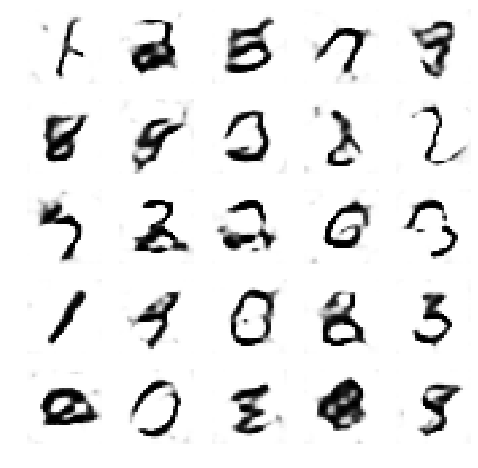

Epoch --> 10


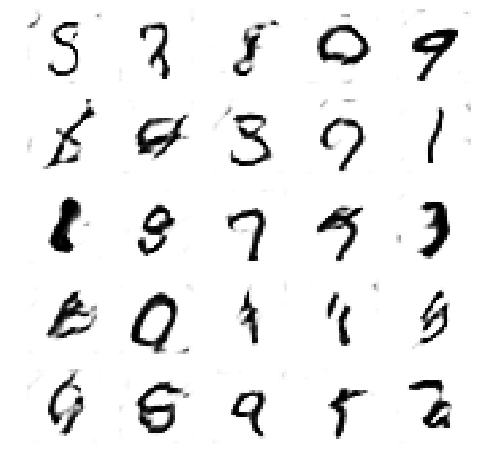

Epoch --> 15


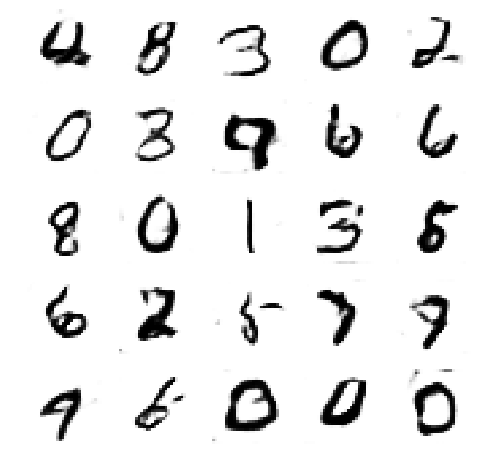

Epoch --> 20


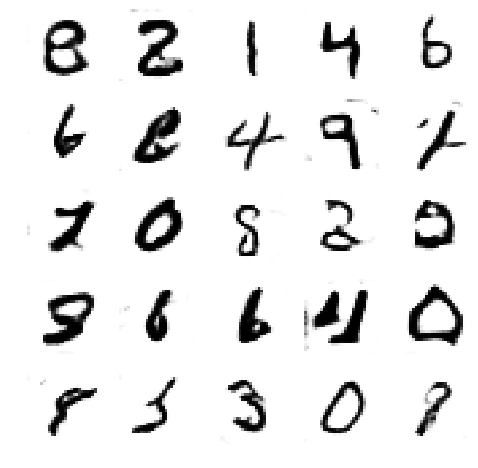

Epoch --> 25


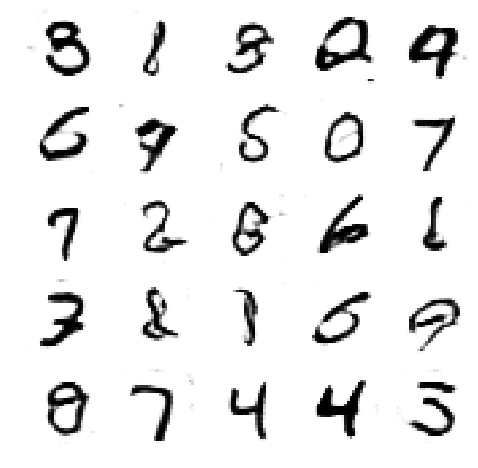

Epoch --> 30


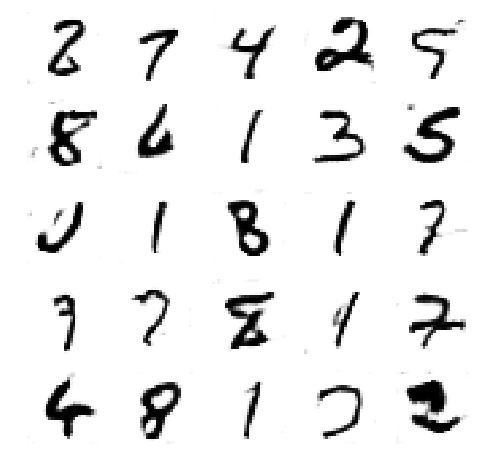

Epoch --> 35


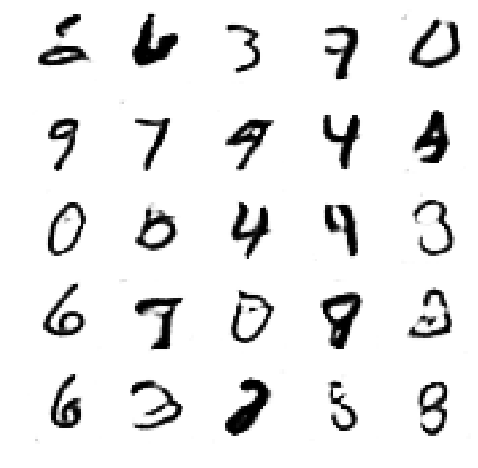

Epoch --> 40


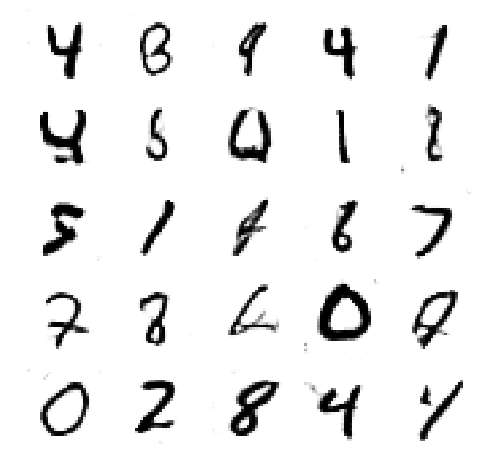

Epoch --> 45


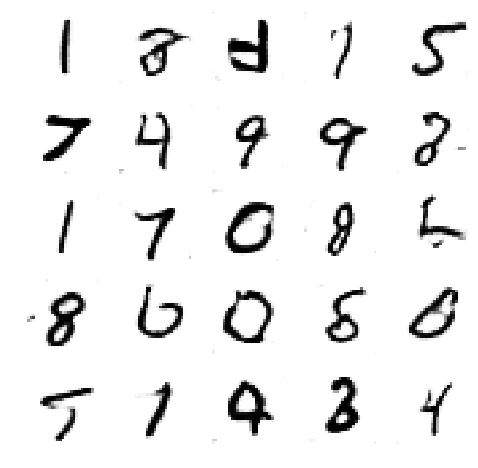

Epoch --> 50


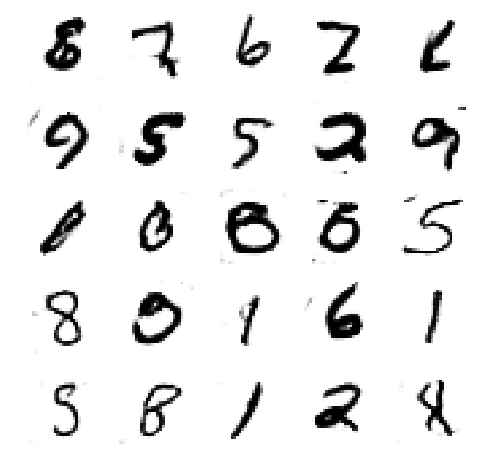

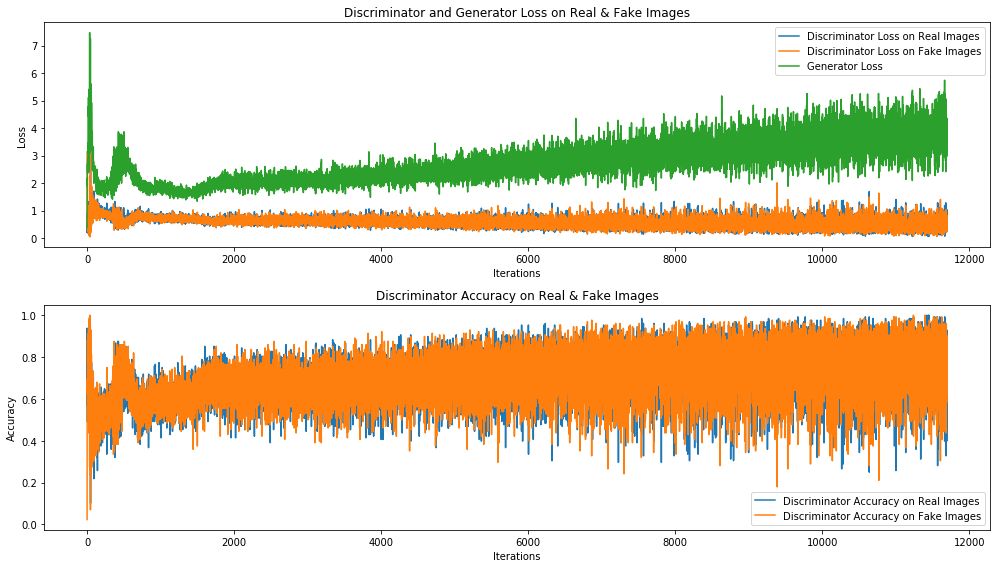

CPU times: user 44min 22s, sys: 21min, total: 1h 5min 23s
Wall time: 1h 32min 56s


In [0]:
# calculate execution time
%%time
# size of latent space
latent_dim = 100
# number of epochs
n_epochs = 50
# create GAN
gan_model = build_gan(g_model, d_model)
# load image dataset
dataset = load_real_samples()
# train GAN
train_gan(g_model, d_model, gan_model, dataset, latent_dim, n_epochs)

## Create GIF

In [0]:
# create a gif from specified intervals
gif_file = 'dcgan-mnist.gif'

with imageio.get_writer(gif_file, mode='I') as writer:
    filenames = glob.glob('image_at_epoch*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
# display the gif
import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=gif_file)

In [0]:
# dowmload the gif
try:
    from google.colab import files
except ImportError:
    pass
else:
    files.download(gif_file)

## Use the Final Generator Model to Generate Images

- Once a final generator model is selected, it can be used in a standalone manner for our application.

- This involves first loading the model from file, then using it to generate images. The generation of each image requires a point in the latent space as input.

- In this case, we will use the model saved after 50 training epochs, but the model saved after 30 or 40 epochs would work just as well.

In [0]:
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
import matplotlib.pyplot as plt

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('generator_model_50.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)

## Use the final Generator Model to generate image for a specific point in latent space

- The latent space now defines a compressed representation of MNIST handwritten digits.

- We can experiment with generating different points in this space and see what types of numbers they generate.

- The example below generates a single handwritten digit using a vector of all 0.0 values.

Note: Your specific results may vary given the stochastic nature of the model and the learning algorithm.

In [0]:
# example of generating an image for a specific point in the latent space
from keras.models import load_model
from numpy import asarray
import matplotlib.pyplot as plt

# load model
model = load_model('generator_model_50.h5')
# all 0s
vector = asarray([[0.0 for _ in range(100)]])
# generate image
X = model.predict(vector)
# plot the result
plt.imshow(X[0, :, :, 0], cmap='gray_r')
plt.show()

## References
[Generative Adversarial Networks (GANs)](https://arxiv.org/pdf/1406.2661.pdf)

[DCGAN on MNIST Dataset using Keras](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/)

[GAN Hacks](https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/)